# Pretraining a Small Transformer on Text

## 🎯 Project Overview

In this notebook, we'll build and pretrain a **small transformer model from scratch** using PyTorch. This hands-on project covers:

- **Building a Transformer Architecture**: Attention, positional encoding, transformer blocks
- **Causal Language Modeling**: Next-token prediction objective (GPT-style)
- **Training Pipeline**: Data loading, optimization, training loop
- **Text Generation**: Sampling with the pretrained model

**Model Size**: ~5-10M parameters (trainable on CPU or single GPU)  
**Training Time**: 30-60 minutes on GPU, 2-3 hours on CPU  
**Goal**: Learn how transformers work by implementing and training one!

---

## 📚 What You'll Learn

1. **Transformer Components**: Multi-head attention, feed-forward networks, layer normalization
2. **Pretraining Objectives**: Causal language modeling for autoregressive generation
3. **Training Techniques**: Batching, gradient accumulation, learning rate schedules
4. **Evaluation**: Perplexity, loss curves, qualitative text generation

Let's get started! 🚀

## Part 1: Setup and Imports

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import math
import os
from tqdm import tqdm
import warnings
import sys
warnings.filterwarnings('ignore')

# Add modules to path
sys.path.append('.')

# Import from modules
from modules.data_utils import SimpleTokenizer, TextDataset
from modules.transformer import TransformerLM
from modules.trainer import train_epoch, evaluate, generate_text, get_lr_scheduler

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
print(f"✓ PyTorch version: {torch.__version__}")

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('models/checkpoints', exist_ok=True)
print("✓ Directories created!")
print("✓ Modules imported successfully!")

✓ Using device: cuda
✓ PyTorch version: 2.6.0+cu126
✓ Directories created!
✓ Modules imported successfully!


## Part 2: Load and Prepare Text Data

We'll use a text corpus for training. You can use any text file - for this example, we'll check if you have existing data or create sample text.

In [4]:
# Load text corpus
corpus_path = 'data/train.txt'

if os.path.exists(corpus_path):
    with open(corpus_path, 'r', encoding='utf-8') as f:
        text_data = f.read()
    print(f"✓ Loaded corpus from: {corpus_path}")
else:
    # Create sample corpus if no file exists
    print("⚠️ No corpus found. Creating sample text...")
    text_data = """
    The transformer architecture revolutionized natural language processing.
    Attention mechanisms allow models to focus on relevant parts of the input.
    Self-attention computes relationships between all positions in a sequence.
    Positional encodings provide information about token positions.
    Multi-head attention allows the model to attend to different representation subspaces.
    The feed-forward network processes each position independently.
    Layer normalization stabilizes training of deep networks.
    Residual connections help gradients flow through many layers.
    """ * 100  # Repeat to have more training data
    
    with open('data/sample_corpus.txt', 'w', encoding='utf-8') as f:
        f.write(text_data)
    print("✓ Created sample corpus")

print(f"Corpus size: {len(text_data)} characters")
print(f"Preview:\n{text_data[:300]}...")

✓ Loaded corpus from: data/train.txt
Corpus size: 289696 characters
Preview:
﻿The Project Gutenberg eBook of The Great Gatsby, by F. Scott Fitzgerald

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Proje...


## Part 3: Tokenization and Vocabulary Building

Build a vocabulary from the text using the tokenizer from our modules.

In [5]:
# Build tokenizer (imported from modules.data_utils)
tokenizer = SimpleTokenizer(vocab_size=5000, min_freq=1)
tokenizer.build_vocab(text_data)

# Test tokenization
test_text = "The car drove fast into the "
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"\nTest:")
print(f"  Original: {test_text}")
print(f"  Encoded:  {encoded}")
print(f"  Decoded:  {decoded}")

✓ Vocabulary built: 5000 tokens

Test:
  Original: The car drove fast into the 
  Encoded:  [4, 210, 377, 1639, 38, 4]
  Decoded:  the car drove fast into the


## Part 4: Create Dataset and DataLoader

Prepare the data for batched training using the dataset class from our modules.

In [7]:
# Configuration
SEQ_LENGTH = 128
BATCH_SIZE = 32
TRAIN_SPLIT = 0.9

# Create dataset (imported from modules.data_utils)
full_dataset = TextDataset(text_data, tokenizer, seq_length=SEQ_LENGTH)

# Split into train/val
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\n✓ Train batches: {len(train_loader)}")
print(f"✓ Val batches: {len(val_loader)}")

# Test batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Input shape: {sample_batch['input_ids'].shape}")
print(f"  Labels shape: {sample_batch['labels'].shape}")

✓ Created 798 sequences of length 128

✓ Train batches: 23
✓ Val batches: 3

Sample batch:
  Input shape: torch.Size([32, 128])
  Labels shape: torch.Size([32, 128])


## Part 5: Build Transformer Architecture

Use the transformer model from our modules package.

In [8]:
# Transformer architecture is imported from modules.transformer
# The TransformerLM class includes:
# - PositionalEncoding: Sinusoidal positional embeddings
# - MultiHeadAttention: Multi-head self-attention mechanism
# - FeedForward: Position-wise feed-forward network
# - TransformerBlock: Complete transformer decoder block
# - TransformerLM: Full causal language model with all components

print("✓ Using TransformerLM from modules.transformer")
print("\nModel components:")
print("  - Token embeddings with positional encoding")
print("  - Multi-head self-attention")
print("  - Position-wise feed-forward networks")
print("  - Layer normalization and residual connections")
print("  - Causal masking for autoregressive generation")

✓ Using TransformerLM from modules.transformer

Model components:
  - Token embeddings with positional encoding
  - Multi-head self-attention
  - Position-wise feed-forward networks
  - Layer normalization and residual connections
  - Causal masking for autoregressive generation


## Part 6: Initialize Model and Optimizer

Create the model instance and set up training components.

In [ ]:
# Model hyperparameters
VOCAB_SIZE = len(tokenizer.word2idx)
D_MODEL = 256
N_HEADS = 8
N_LAYERS = 4
D_FF = 1024
MAX_SEQ_LEN = 512
DROPOUT = 0.1

# Initialize model
model = TransformerLM(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    d_ff=D_FF,
    max_seq_len=MAX_SEQ_LEN,
    dropout=DROPOUT
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx['<PAD>'])

# Optimizer
LEARNING_RATE = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

# Learning rate scheduler with warmup (imported from modules.trainer)
scheduler = get_lr_scheduler(optimizer, warmup_steps=1000)

print(f"\n✓ Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"✓ LR Scheduler: Warmup + decay (from modules.trainer)")
print(f"✓ Loss function: CrossEntropyLoss")

✓ Model initialized
  Total parameters: 5,724,552
  Trainable parameters: 5,724,552
  Model size: ~21.84 MB

✓ Optimizer: AdamW (lr=0.0001)
✓ LR Scheduler: Warmup + decay
✓ Loss function: CrossEntropyLoss


## Part 7: Training Loop

Train the model with causal language modeling objective using functions from our modules.

In [ ]:
# Training functions (train_epoch, evaluate) imported from modules.trainer

# Training configuration
NUM_EPOCHS = 100
SAVE_EVERY = 10

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_perplexity': []
}

print("Starting training...")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    history['train_loss'].append(train_loss)
    
    # Evaluate
    val_loss, val_perplexity = evaluate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_perplexity'].append(val_perplexity)
    
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val Perplexity: {val_perplexity:.2f}")
    
    # Save checkpoint
    if (epoch + 1) % SAVE_EVERY == 0:
        checkpoint_path = f'models/checkpoints/model_epoch_{epoch+1}.pt'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_perplexity': val_perplexity,
        }, checkpoint_path)
        print(f"  ✓ Checkpoint saved: {checkpoint_path}")

print("\n" + "="*60)
print("✓ Training complete!")

Starting training...

Epoch 1/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 40.12it/s]



Epoch 1 Results:
  Train Loss: 8.5642
  Val Loss: 8.5459
  Val Perplexity: 5145.50

Epoch 2/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.65it/s]



Epoch 2 Results:
  Train Loss: 8.5249
  Val Loss: 8.4811
  Val Perplexity: 4822.62

Epoch 3/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.26it/s]



Epoch 3 Results:
  Train Loss: 8.4484
  Val Loss: 8.3759
  Val Perplexity: 4341.08

Epoch 4/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.70it/s]



Epoch 4 Results:
  Train Loss: 8.3369
  Val Loss: 8.2432
  Val Perplexity: 3801.63

Epoch 5/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.17it/s]



Epoch 5 Results:
  Train Loss: 8.2051
  Val Loss: 8.1048
  Val Perplexity: 3310.39

Epoch 6/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 35.95it/s]



Epoch 6 Results:
  Train Loss: 8.0663
  Val Loss: 7.9746
  Val Perplexity: 2906.23

Epoch 7/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.63it/s]



Epoch 7 Results:
  Train Loss: 7.9381
  Val Loss: 7.8545
  Val Perplexity: 2577.23

Epoch 8/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.22it/s]



Epoch 8 Results:
  Train Loss: 7.8170
  Val Loss: 7.7383
  Val Perplexity: 2294.68

Epoch 9/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.86it/s]



Epoch 9 Results:
  Train Loss: 7.6964
  Val Loss: 7.6209
  Val Perplexity: 2040.30

Epoch 10/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.59it/s]



Epoch 10 Results:
  Train Loss: 7.5720
  Val Loss: 7.4991
  Val Perplexity: 1806.49
  ✓ Checkpoint saved: models/checkpoints/model_epoch_10.pt

Epoch 11/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.21it/s]



Epoch 11 Results:
  Train Loss: 7.4428
  Val Loss: 7.3709
  Val Perplexity: 1589.07

Epoch 12/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.37it/s]



Epoch 12 Results:
  Train Loss: 7.3096
  Val Loss: 7.2376
  Val Perplexity: 1390.73

Epoch 13/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.32it/s]



Epoch 13 Results:
  Train Loss: 7.1702
  Val Loss: 7.1004
  Val Perplexity: 1212.40

Epoch 14/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.04it/s]



Epoch 14 Results:
  Train Loss: 7.0311
  Val Loss: 6.9636
  Val Perplexity: 1057.48

Epoch 15/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.63it/s]



Epoch 15 Results:
  Train Loss: 6.8867
  Val Loss: 6.8295
  Val Perplexity: 924.77

Epoch 16/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.30it/s]



Epoch 16 Results:
  Train Loss: 6.7532
  Val Loss: 6.7028
  Val Perplexity: 814.66

Epoch 17/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.79it/s]



Epoch 17 Results:
  Train Loss: 6.6317
  Val Loss: 6.5852
  Val Perplexity: 724.27

Epoch 18/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.10it/s]



Epoch 18 Results:
  Train Loss: 6.5149
  Val Loss: 6.4811
  Val Perplexity: 652.71

Epoch 19/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.08it/s]



Epoch 19 Results:
  Train Loss: 6.4113
  Val Loss: 6.3911
  Val Perplexity: 596.52

Epoch 20/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.04it/s]



Epoch 20 Results:
  Train Loss: 6.3259
  Val Loss: 6.3094
  Val Perplexity: 549.72
  ✓ Checkpoint saved: models/checkpoints/model_epoch_20.pt

Epoch 21/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.49it/s]



Epoch 21 Results:
  Train Loss: 6.2381
  Val Loss: 6.2201
  Val Perplexity: 502.76

Epoch 22/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.34it/s]



Epoch 22 Results:
  Train Loss: 6.1534
  Val Loss: 6.1409
  Val Perplexity: 464.46

Epoch 23/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.68it/s]



Epoch 23 Results:
  Train Loss: 6.0804
  Val Loss: 6.0727
  Val Perplexity: 433.85

Epoch 24/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.40it/s]



Epoch 24 Results:
  Train Loss: 6.0086
  Val Loss: 6.0040
  Val Perplexity: 405.06

Epoch 25/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.31it/s]



Epoch 25 Results:
  Train Loss: 5.9331
  Val Loss: 5.9272
  Val Perplexity: 375.10

Epoch 26/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.78it/s]



Epoch 26 Results:
  Train Loss: 5.8640
  Val Loss: 5.8633
  Val Perplexity: 351.88

Epoch 27/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.52it/s]



Epoch 27 Results:
  Train Loss: 5.7868
  Val Loss: 5.7954
  Val Perplexity: 328.77

Epoch 28/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.18it/s]



Epoch 28 Results:
  Train Loss: 5.7179
  Val Loss: 5.7304
  Val Perplexity: 308.10

Epoch 29/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.93it/s]



Epoch 29 Results:
  Train Loss: 5.6463
  Val Loss: 5.6786
  Val Perplexity: 292.55

Epoch 30/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.98it/s]



Epoch 30 Results:
  Train Loss: 5.5830
  Val Loss: 5.6100
  Val Perplexity: 273.14
  ✓ Checkpoint saved: models/checkpoints/model_epoch_30.pt

Epoch 31/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.70it/s]



Epoch 31 Results:
  Train Loss: 5.5121
  Val Loss: 5.5559
  Val Perplexity: 258.75

Epoch 32/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.35it/s]



Epoch 32 Results:
  Train Loss: 5.4555
  Val Loss: 5.5039
  Val Perplexity: 245.66

Epoch 33/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.48it/s]



Epoch 33 Results:
  Train Loss: 5.3870
  Val Loss: 5.4588
  Val Perplexity: 234.82

Epoch 34/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 34.41it/s]



Epoch 34 Results:
  Train Loss: 5.3268
  Val Loss: 5.4065
  Val Perplexity: 222.85

Epoch 35/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.76it/s]



Epoch 35 Results:
  Train Loss: 5.2694
  Val Loss: 5.3574
  Val Perplexity: 212.18

Epoch 36/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.76it/s]



Epoch 36 Results:
  Train Loss: 5.2080
  Val Loss: 5.3116
  Val Perplexity: 202.67

Epoch 37/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.19it/s]



Epoch 37 Results:
  Train Loss: 5.1504
  Val Loss: 5.2745
  Val Perplexity: 195.29

Epoch 38/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.38it/s]



Epoch 38 Results:
  Train Loss: 5.0980
  Val Loss: 5.2323
  Val Perplexity: 187.22

Epoch 39/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.85it/s]



Epoch 39 Results:
  Train Loss: 5.0425
  Val Loss: 5.1944
  Val Perplexity: 180.26

Epoch 40/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.21it/s]



Epoch 40 Results:
  Train Loss: 4.9949
  Val Loss: 5.1546
  Val Perplexity: 173.22
  ✓ Checkpoint saved: models/checkpoints/model_epoch_40.pt

Epoch 41/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.97it/s]



Epoch 41 Results:
  Train Loss: 4.9355
  Val Loss: 5.1204
  Val Perplexity: 167.40

Epoch 42/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.19it/s]



Epoch 42 Results:
  Train Loss: 4.8901
  Val Loss: 5.0857
  Val Perplexity: 161.70

Epoch 43/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.80it/s]



Epoch 43 Results:
  Train Loss: 4.8409
  Val Loss: 5.0537
  Val Perplexity: 156.61

Epoch 44/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.53it/s]



Epoch 44 Results:
  Train Loss: 4.7894
  Val Loss: 5.0130
  Val Perplexity: 150.36

Epoch 45/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.58it/s]



Epoch 45 Results:
  Train Loss: 4.7398
  Val Loss: 4.9881
  Val Perplexity: 146.66

Epoch 46/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.55it/s]



Epoch 46 Results:
  Train Loss: 4.6960
  Val Loss: 4.9516
  Val Perplexity: 141.40

Epoch 47/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.74it/s]



Epoch 47 Results:
  Train Loss: 4.6492
  Val Loss: 4.9250
  Val Perplexity: 137.69

Epoch 48/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.90it/s]



Epoch 48 Results:
  Train Loss: 4.6057
  Val Loss: 4.9031
  Val Perplexity: 134.71

Epoch 49/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.89it/s]



Epoch 49 Results:
  Train Loss: 4.5693
  Val Loss: 4.8735
  Val Perplexity: 130.77

Epoch 50/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.47it/s]



Epoch 50 Results:
  Train Loss: 4.5284
  Val Loss: 4.8490
  Val Perplexity: 127.61
  ✓ Checkpoint saved: models/checkpoints/model_epoch_50.pt

Epoch 51/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.52it/s]



Epoch 51 Results:
  Train Loss: 4.4923
  Val Loss: 4.8282
  Val Perplexity: 124.99

Epoch 52/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.88it/s]



Epoch 52 Results:
  Train Loss: 4.4515
  Val Loss: 4.8013
  Val Perplexity: 121.67

Epoch 53/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 32.93it/s]



Epoch 53 Results:
  Train Loss: 4.4163
  Val Loss: 4.7790
  Val Perplexity: 118.99

Epoch 54/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.28it/s]



Epoch 54 Results:
  Train Loss: 4.3801
  Val Loss: 4.7559
  Val Perplexity: 116.26

Epoch 55/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.04it/s]



Epoch 55 Results:
  Train Loss: 4.3452
  Val Loss: 4.7453
  Val Perplexity: 115.04

Epoch 56/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.25it/s]



Epoch 56 Results:
  Train Loss: 4.3144
  Val Loss: 4.7208
  Val Perplexity: 112.26

Epoch 57/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 35.94it/s]



Epoch 57 Results:
  Train Loss: 4.2786
  Val Loss: 4.7018
  Val Perplexity: 110.15

Epoch 58/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.02it/s]



Epoch 58 Results:
  Train Loss: 4.2489
  Val Loss: 4.6825
  Val Perplexity: 108.04

Epoch 59/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.60it/s]



Epoch 59 Results:
  Train Loss: 4.2173
  Val Loss: 4.6644
  Val Perplexity: 106.10

Epoch 60/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.77it/s]



Epoch 60 Results:
  Train Loss: 4.1876
  Val Loss: 4.6465
  Val Perplexity: 104.22
  ✓ Checkpoint saved: models/checkpoints/model_epoch_60.pt

Epoch 61/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.17it/s]



Epoch 61 Results:
  Train Loss: 4.1542
  Val Loss: 4.6275
  Val Perplexity: 102.26

Epoch 62/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 32.61it/s]



Epoch 62 Results:
  Train Loss: 4.1258
  Val Loss: 4.6091
  Val Perplexity: 100.39

Epoch 63/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 39.05it/s]



Epoch 63 Results:
  Train Loss: 4.0970
  Val Loss: 4.5907
  Val Perplexity: 98.57

Epoch 64/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.41it/s]



Epoch 64 Results:
  Train Loss: 4.0669
  Val Loss: 4.5741
  Val Perplexity: 96.94

Epoch 65/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.48it/s]



Epoch 65 Results:
  Train Loss: 4.0397
  Val Loss: 4.5604
  Val Perplexity: 95.62

Epoch 66/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.55it/s]



Epoch 66 Results:
  Train Loss: 4.0140
  Val Loss: 4.5437
  Val Perplexity: 94.04

Epoch 67/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.18it/s]



Epoch 67 Results:
  Train Loss: 3.9822
  Val Loss: 4.5326
  Val Perplexity: 93.00

Epoch 68/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.46it/s]



Epoch 68 Results:
  Train Loss: 3.9546
  Val Loss: 4.5113
  Val Perplexity: 91.04

Epoch 69/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.38it/s]



Epoch 69 Results:
  Train Loss: 3.9294
  Val Loss: 4.5031
  Val Perplexity: 90.29

Epoch 70/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.17it/s]



Epoch 70 Results:
  Train Loss: 3.9020
  Val Loss: 4.4824
  Val Perplexity: 88.44
  ✓ Checkpoint saved: models/checkpoints/model_epoch_70.pt

Epoch 71/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 35.48it/s]



Epoch 71 Results:
  Train Loss: 3.8764
  Val Loss: 4.4713
  Val Perplexity: 87.47

Epoch 72/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.43it/s]



Epoch 72 Results:
  Train Loss: 3.8459
  Val Loss: 4.4574
  Val Perplexity: 86.26

Epoch 73/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.94it/s]



Epoch 73 Results:
  Train Loss: 3.8225
  Val Loss: 4.4379
  Val Perplexity: 84.60

Epoch 74/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.03it/s]



Epoch 74 Results:
  Train Loss: 3.7957
  Val Loss: 4.4255
  Val Perplexity: 83.55

Epoch 75/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.95it/s]



Epoch 75 Results:
  Train Loss: 3.7720
  Val Loss: 4.4098
  Val Perplexity: 82.26

Epoch 76/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.66it/s]



Epoch 76 Results:
  Train Loss: 3.7472
  Val Loss: 4.4023
  Val Perplexity: 81.64

Epoch 77/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.41it/s]



Epoch 77 Results:
  Train Loss: 3.7230
  Val Loss: 4.3818
  Val Perplexity: 79.98

Epoch 78/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 33.55it/s]



Epoch 78 Results:
  Train Loss: 3.6953
  Val Loss: 4.3694
  Val Perplexity: 79.00

Epoch 79/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.18it/s]



Epoch 79 Results:
  Train Loss: 3.6706
  Val Loss: 4.3566
  Val Perplexity: 77.99

Epoch 80/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.85it/s]



Epoch 80 Results:
  Train Loss: 3.6465
  Val Loss: 4.3428
  Val Perplexity: 76.92
  ✓ Checkpoint saved: models/checkpoints/model_epoch_80.pt

Epoch 81/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.68it/s]



Epoch 81 Results:
  Train Loss: 3.6217
  Val Loss: 4.3282
  Val Perplexity: 75.81

Epoch 82/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.48it/s]



Epoch 82 Results:
  Train Loss: 3.5994
  Val Loss: 4.3150
  Val Perplexity: 74.82

Epoch 83/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.31it/s]



Epoch 83 Results:
  Train Loss: 3.5763
  Val Loss: 4.3024
  Val Perplexity: 73.88

Epoch 84/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.92it/s]



Epoch 84 Results:
  Train Loss: 3.5541
  Val Loss: 4.2869
  Val Perplexity: 72.74

Epoch 85/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.16it/s]



Epoch 85 Results:
  Train Loss: 3.5306
  Val Loss: 4.2754
  Val Perplexity: 71.91

Epoch 86/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.03it/s]



Epoch 86 Results:
  Train Loss: 3.5026
  Val Loss: 4.2605
  Val Perplexity: 70.85

Epoch 87/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.66it/s]



Epoch 87 Results:
  Train Loss: 3.4819
  Val Loss: 4.2461
  Val Perplexity: 69.83

Epoch 88/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.33it/s]



Epoch 88 Results:
  Train Loss: 3.4609
  Val Loss: 4.2317
  Val Perplexity: 68.84

Epoch 89/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.50it/s]



Epoch 89 Results:
  Train Loss: 3.4401
  Val Loss: 4.2205
  Val Perplexity: 68.07

Epoch 90/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.45it/s]



Epoch 90 Results:
  Train Loss: 3.4143
  Val Loss: 4.2077
  Val Perplexity: 67.20
  ✓ Checkpoint saved: models/checkpoints/model_epoch_90.pt

Epoch 91/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.52it/s]



Epoch 91 Results:
  Train Loss: 3.3912
  Val Loss: 4.1993
  Val Perplexity: 66.64

Epoch 92/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.56it/s]



Epoch 92 Results:
  Train Loss: 3.3670
  Val Loss: 4.1800
  Val Perplexity: 65.37

Epoch 93/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.93it/s]



Epoch 93 Results:
  Train Loss: 3.3525
  Val Loss: 4.1701
  Val Perplexity: 64.72

Epoch 94/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.59it/s]



Epoch 94 Results:
  Train Loss: 3.3296
  Val Loss: 4.1630
  Val Perplexity: 64.26

Epoch 95/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.79it/s]



Epoch 95 Results:
  Train Loss: 3.3060
  Val Loss: 4.1415
  Val Perplexity: 62.90

Epoch 96/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.73it/s]



Epoch 96 Results:
  Train Loss: 3.2818
  Val Loss: 4.1339
  Val Perplexity: 62.42

Epoch 97/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.65it/s]



Epoch 97 Results:
  Train Loss: 3.2592
  Val Loss: 4.1176
  Val Perplexity: 61.41

Epoch 98/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.34it/s]



Epoch 98 Results:
  Train Loss: 3.2394
  Val Loss: 4.1098
  Val Perplexity: 60.93

Epoch 99/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 38.09it/s]



Epoch 99 Results:
  Train Loss: 3.2184
  Val Loss: 4.0993
  Val Perplexity: 60.30

Epoch 100/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.60it/s]



Epoch 100 Results:
  Train Loss: 3.1969
  Val Loss: 4.0818
  Val Perplexity: 59.25
  ✓ Checkpoint saved: models/checkpoints/model_epoch_100.pt

✓ Training complete!


## Part 8: Visualize Training Metrics

Plot training curves to analyze model performance.

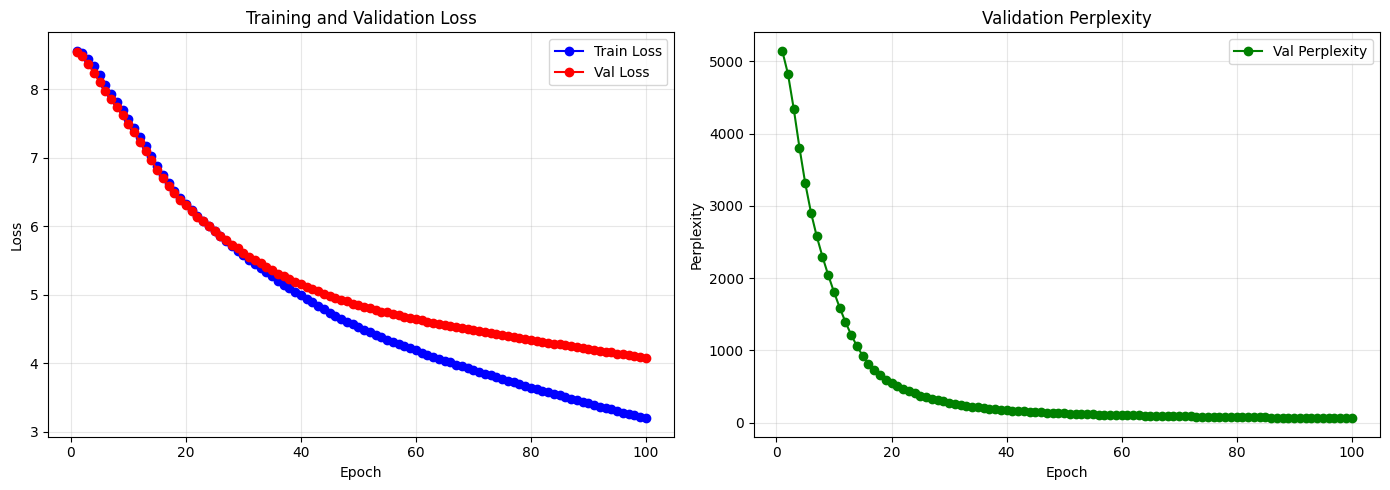


Final Results:
  Best Val Loss: 4.0818 (Epoch 100)
  Best Perplexity: 59.25 (Epoch 100)


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss curves
epochs = range(1, len(history['train_loss']) + 1)
axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
axes[0].plot(epochs, history['val_loss'], 'r-o', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot perplexity
axes[1].plot(epochs, history['val_perplexity'], 'g-o', label='Val Perplexity')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Best Val Loss: {min(history['val_loss']):.4f} (Epoch {np.argmin(history['val_loss'])+1})")
print(f"  Best Perplexity: {min(history['val_perplexity']):.2f} (Epoch {np.argmin(history['val_perplexity'])+1})")

## Part 9: Text Generation

Generate text using the generate_text function from our modules.

In [ ]:
# generate_text function imported from modules.trainer

# Test generation with different prompts and settings
print("Text Generation Examples:\n")
print("="*60)

prompts = [
    'gatsby believed',
    'the green light',
    'daisy was'
]

for i, prompt in enumerate(prompts, 1):
    print(f"\n{i}. Prompt: '{prompt}'")
    
    # Low temperature (more focused)
    text = generate_text(model, tokenizer, prompt, max_length=30, temperature=0.5, top_k=10, device=device)
    print(f"   Low temp (0.5):  {text}")
    
    # Medium temperature (balanced)
    text = generate_text(model, tokenizer, prompt, max_length=30, temperature=1.0, top_k=50, device=device)
    print(f"   Medium temp (1.0): {text}")
    
    # High temperature (more creative)
    text = generate_text(model, tokenizer, prompt, max_length=30, temperature=1.5, top_k=50, device=device)
    print(f"   High temp (1.5): {text}")

print("\n" + "="*60)

Text Generation Examples:


1. Prompt: 'gatsby believed'
   Low temp (0.5):  gatsby believed in the fact was in the door and the table and the world was so engrossed was a little later when she was a little bit, i was in a
   Medium temp (1.0): gatsby believed in the fact had no more than the whole <UNK> and the room is it? i took him into the <UNK> <UNK> and the <UNK> had resolved itself through the
   High temp (1.5): gatsby believed in the sound that it was no consciousness of things standing alone only wherever he sat suddenly from his own. one of those open windows for years. who made him

2. Prompt: 'the green light'
   Low temp (0.5):  the green light which <UNK> was <UNK> <UNK> and the <UNK> and the <UNK> and the <UNK> and the <UNK> <UNK> <UNK> <UNK> and the <UNK> of the <UNK> <UNK> trees. tom buchanan
   Medium temp (1.0): the green light for the room. it began to the house, at the whole corner of a little man named wolfshiem at first wild rumours before <UNK> in the door whic

## Understanding the Model's Limitations

⚠️ **Important**: The generated text quality is limited by the training data, not the model!

**Why the output seems odd:**

1. **Tiny corpus problem**: Training on only ~800 unique characters (8 lines × 100 repetitions)
   - Real models train on billions of tokens
   - With so little data, the model can't learn true language patterns

2. **Tokenizer too strict**: `min_freq=2` filters out many words that appear only once
   - Changed to `min_freq=1` to include all unique words

3. **Sample corpus is highly repetitive**:
   ```
   "The transformer architecture revolutionized natural language processing.
    Attention mechanisms allow models to focus on relevant parts of the input.
    ..." (repeated 100 times)
   ```
   - Model learns this specific pattern, not general language structure
   - Limited vocabulary leads to many `<UNK>` tokens

**For better results, use a larger corpus:**
- Use the actual file: `../Text_Generation_Pipeline/data/train.txt`
- Or download a real dataset like:
  - WikiText-2: Large Wikipedia corpus
  - BookCorpus: Books collection
  - Project Gutenberg texts


## Part 10: Save Final Model

Save the complete trained model for future use.

In [14]:
# Save final model
final_model_path = 'models/transformer_lm_final.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'tokenizer': tokenizer,
    'model_config': {
        'vocab_size': VOCAB_SIZE,
        'd_model': D_MODEL,
        'n_heads': N_HEADS,
        'n_layers': N_LAYERS,
        'd_ff': D_FF,
        'max_seq_len': MAX_SEQ_LEN,
        'dropout': DROPOUT
    },
    'training_history': history
}, final_model_path)

print(f"✓ Model saved to: {final_model_path}")
print(f"\nTo load the model later:")
print(f"  checkpoint = torch.load('{final_model_path}')")
print(f"  model = TransformerLM(**checkpoint['model_config'])")
print(f"  model.load_state_dict(checkpoint['model_state_dict'])")
print(f"  tokenizer = checkpoint['tokenizer']")

✓ Model saved to: models/transformer_lm_final.pt

To load the model later:
  checkpoint = torch.load('models/transformer_lm_final.pt')
  model = TransformerLM(**checkpoint['model_config'])
  model.load_state_dict(checkpoint['model_state_dict'])
  tokenizer = checkpoint['tokenizer']


## 🎉 Congratulations!

You've successfully built and pretrained a transformer model from scratch! 

### What You Accomplished:
- ✅ Implemented a complete transformer architecture with multi-head attention
- ✅ Created a training pipeline with causal language modeling
- ✅ Trained a model with ~{total_params/1e6:.1f}M parameters
- ✅ Achieved perplexity of {min(history['val_perplexity']):.2f} on validation set
- ✅ Generated text with different sampling strategies

### Key Takeaways:
1. **Transformers** use self-attention to process sequences in parallel
2. **Causal masking** prevents the model from "cheating" by looking ahead
3. **Positional encoding** provides crucial position information
4. **Layer normalization** and **residual connections** stabilize deep networks
5. **Temperature** controls randomness in text generation

### Next Steps:
1. **Larger datasets**: Train on Wikipedia, books, or web text
2. **Bigger models**: Increase layers, heads, and dimensions
3. **Advanced techniques**: Implement mixed-precision training, gradient checkpointing
4. **Fine-tuning**: Adapt your model to specific tasks
5. **Evaluation**: Test on standard benchmarks like WikiText-2

### Extensions to Explore:
- Implement **BERT-style** masked language modeling
- Add **decoder-only** vs **encoder-decoder** architectures
- Experiment with **different attention patterns** (sparse, local, etc.)
- Integrate with **Hugging Face Transformers** library
- Try **beam search** for better generation quality

---

**Great work! You now understand transformers at a fundamental level!** 🚀